In [1]:
import sys

sys.path.append('../')

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchviz import make_dot
from cgen.graph import BackpropGraph, iKannForwardGraph

SyntaxError: invalid syntax (graph.py, line 47)

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        return x
    
class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=(2,2), stride=(2, 2))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2, 2))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        return x

In [2]:
net = Net()
x = Variable(torch.rand(1, 3))
y = net(x)

NameError: name 'Net' is not defined

In [3]:
b = BackpropGraph(net)
b.parse(y)
b.g

NameError: name 'BackpropGraph' is not defined

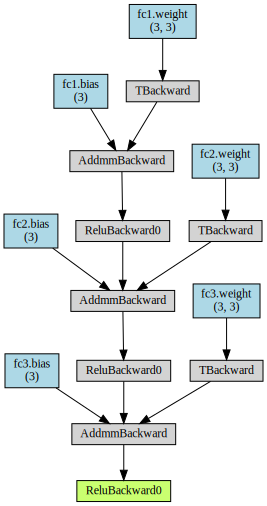

In [5]:
make_dot(y, params=dict(net.named_parameters()))

In [6]:
k = iKannForwardGraph()
k.parse(b.g)
k.g

start :
{'name': 'TBackward', 'children': [140557090494448]}
TBackward's child : 140557090494448
{'name': 'AccumulateGrad', 'weights': tensor([-0.0655,  0.2207,  0.2813]), 'size': torch.Size([3]), 'children': []}
start :
{'name': 'TBackward', 'children': [140557090493632]}
TBackward's child : 140557090493632
start :
{'name': 'TBackward', 'children': [140557090494160]}
TBackward's child : 140557090494160


{0: {'name': 'relu', 'output': True},
 1: {'name': 'dense',
  'bias': {'value': tensor([-0.1555,  0.4730, -0.4635]),
   'size': torch.Size([3])},
  'weights': {'value': tensor([-0.0655,  0.2207,  0.2813]),
   'size': torch.Size([3])},
  'next': 0},
 2: {'name': 'relu', 'next': 1},
 3: {'name': 'dense',
  'bias': {'value': tensor([ 0.5208, -0.0018, -0.1439]),
   'size': torch.Size([3])},
  'weights': {'value': tensor([-0.0655,  0.2207,  0.2813]),
   'size': torch.Size([3])},
  'next': 2},
 4: {'name': 'relu', 'next': 3},
 5: {'name': 'dense',
  'bias': {'value': tensor([-0.0655,  0.2207,  0.2813]),
   'size': torch.Size([3])},
  'weights': {'value': tensor([[ 0.1144, -0.3504,  0.2197],
           [ 0.0649,  0.0643,  0.5467],
           [ 0.2475,  0.2352,  0.3304]]),
   'size': torch.Size([3, 3])},
  'next': 4}}

In [6]:
var = y

In [7]:
output_nodes = (var.grad_fn,) if not isinstance(var, tuple) else tuple(v.grad_fn for v in var)
seen = set()
params = dict(net.named_parameters())
param_map = {id(v): k for k, v in params.items()}
count = 0
graph = {}

def size_to_str(size):
    return '(' + (', ').join(['%d' % v for v in size]) + ')'


def add_nodes(var):
    global count
    print(f'count: {count}')
    count += 1
    if var in seen:
        print(f'var: {var} has been seen')
    else:
        vId = id(var)
        graph[vId] = {'name': str(type(var).__name__)}
        print(f"output_node: {graph[vId]['name']}")
        
        if torch.is_tensor(var):
            print(f'var is tensor!! node: {str(id(var))}, size: {size_to_str(var.size())}')

        elif hasattr(var, 'variable'):
            u = var.variable
            name = param_map[id(u)] if params is not None else ''
            print(f'var has variable!! node_name: {name}, size: {size_to_str(u.size())}')
#             print(type(u))
#             graph[vId]['name'] = name 
            graph[vId]['weights'] = u.data
        elif var in output_nodes:
            name = str(type(var).__name__)
            graph[vId]['output'] = True
            
        seen.add(var)
        
        if hasattr(var, 'next_functions'):
            graph[vId]['children'] = []
            for u in var.next_functions:
                if u[0] is not None:
                    add_nodes(u[0])
                    graph[vId]['children'].append(id(u[0]))
                    
        if hasattr(var, 'saved_tensors'):
            for t in var.saved_tensors:
                add_nodes(t)
        
        

In [28]:
param_map

{140564893046272: 'fc1.weight',
 140564893047552: 'fc1.bias',
 140564893046208: 'fc2.weight',
 140564893046912: 'fc2.bias',
 140564893046400: 'fc3.weight',
 140564893046528: 'fc3.bias'}

In [8]:
if isinstance(var, tuple):
    for v in var:
        add_nodes(v.grad_fn)
else:
    add_nodes(var.grad_fn)

count: 0
output_node: ReluBackward0
count: 1
output_node: AddmmBackward
count: 2
output_node: AccumulateGrad
var has variable!! node_name: fc3.bias, size: (3)
count: 3
output_node: ReluBackward0
count: 4
output_node: AddmmBackward
count: 5
output_node: AccumulateGrad
var has variable!! node_name: fc2.bias, size: (3)
count: 6
output_node: ReluBackward0
count: 7
output_node: AddmmBackward
count: 8
output_node: AccumulateGrad
var has variable!! node_name: fc1.bias, size: (3)
count: 9
output_node: TBackward
count: 10
output_node: AccumulateGrad
var has variable!! node_name: fc1.weight, size: (3, 3)
count: 11
output_node: TBackward
count: 12
output_node: AccumulateGrad
var has variable!! node_name: fc2.weight, size: (3, 3)
count: 13
output_node: TBackward
count: 14
output_node: AccumulateGrad
var has variable!! node_name: fc3.weight, size: (3, 3)


In [9]:
graph

{140401549878032: {'name': 'ReluBackward0',
  'output': True,
  'children': [140401549912864]},
 140401549912864: {'name': 'AddmmBackward',
  'children': [140401549913344, 140401549913200, 140401549912768]},
 140401549913344: {'name': 'AccumulateGrad',
  'weights': tensor([-0.1590,  0.5126,  0.1095]),
  'children': []},
 140401549913200: {'name': 'ReluBackward0', 'children': [140401520754256]},
 140401520754256: {'name': 'AddmmBackward',
  'children': [140401520753248, 140401520754112, 140401520752720]},
 140401520753248: {'name': 'AccumulateGrad',
  'weights': tensor([-0.0781,  0.4064, -0.4263]),
  'children': []},
 140401520754112: {'name': 'ReluBackward0', 'children': [140401547503792]},
 140401547503792: {'name': 'AddmmBackward',
  'children': [140401547502784, 140401547502880]},
 140401547502784: {'name': 'AccumulateGrad',
  'weights': tensor([-0.1214, -0.3841,  0.0750]),
  'children': []},
 140401547502880: {'name': 'TBackward', 'children': [140401547503456]},
 140401547503456: {

In [12]:
net2 = Net2()
x = Variable(torch.rand(1, 1, 4, 4))
y = net2(x)

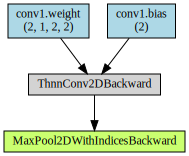

In [13]:
make_dot(y, params=dict(net2.named_parameters()))

In [14]:
net2 = Net2()
x = Variable(torch.rand(1, 1, 4, 4))
y = net2(x)
params = dict(net2.named_parameters())
param_map = {id(v): k for k, v in params.items()}
param_map

{140502891387008: 'conv1.weight', 140502891387520: 'conv1.bias'}

In [15]:
graph = {}
if isinstance(y, tuple):
    for v in y:
        add_nodes(v.grad_fn)
else:
    add_nodes(y.grad_fn)

count: 15
output_node: MaxPool2DWithIndicesBackward
count: 16
output_node: ThnnConv2DBackward
count: 17
output_node: AccumulateGrad
var has variable!! node_name: conv1.weight, size: (2, 1, 2, 2)
count: 18
output_node: AccumulateGrad
var has variable!! node_name: conv1.bias, size: (2)


In [16]:
graph

{140502891368704: {'name': 'MaxPool2DWithIndicesBackward',
  'children': [140502863579984]},
 140502863579984: {'name': 'ThnnConv2DBackward',
  'children': [140502891347296, 140502891345952]},
 140502891347296: {'name': 'AccumulateGrad',
  'weights': tensor([[[[ 0.2478,  0.3611],
            [-0.4316, -0.0692]]],
  
  
          [[[-0.2057,  0.0128],
            [-0.3734, -0.0413]]]]),
  'children': []},
 140502891345952: {'name': 'AccumulateGrad',
  'weights': tensor([ 0.0015, -0.3795]),
  'children': []}}